In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
np.set_printoptions(precision=128)

In [2]:
def fderright(x, fx, h):
    gradFx1 = (f(x + h*np.array([1, 0])) - fx) / h
    gradFx2 = (f(x + h*np.array([0, 1])) - fx) / h
    return np.array([gradFx1, gradFx2])

def fderleft(x, fx, h):
    gradFx1 = (fx - f(x - h*np.array([1, 0]))) / h
    gradFx2 = (fx - f(x - h*np.array([0, 1]))) / h
    return np.array([gradFx1, gradFx2])

def fdercenter(x, h):
    gradFx1 = (f(x + h*np.array([1, 0])) - f(x - h*np.array([1, 0]))) / (2*h)
    gradFx2 = (f(x + h*np.array([0, 1])) - f(x - h*np.array([0, 1]))) / (2*h)
    return np.array([gradFx1, gradFx2])

def fder(x, fx, h, type):
    if type == 'right':
        return fderright(x, fx, h)
    if type == 'left':
        return fderleft(x, fx, h)
    if type == 'center':
        return fdercenter(x, h)
    else:
        raise Exception('Not valid type')
    

In [3]:
def norm(x):
    x1 = x[0]
    x2 = x[1]
    return math.sqrt(x1**2 + x2**2)

def stopCriteria1(xk, fxk, xk_1, fxk_1, e):
    if ((norm(xk_1 - xk) / norm(xk)) <= e) and (math.fabs(fxk_1 - fxk) <= e):
        return True
    return False

def stopCriteria2(gradFxk, e):
    if (norm(gradFxk) <= e):
        return True
    return False

In [4]:
# Code for finding optimal Lambda
functionCalculatedForLambda = 0

svenCoefLambda = 0.01 # 0.00001 # 0.000098
l0 = 0

eGoldenCut = 0.001 # 0.1 # 0.11
eDSKPauela = 0.001

'''
def f(x):
    x1 = x[0]
    x2 = x[1]
    return 3*(x1-15)**  2 -x1*x2 +4*x2**2
''' 

def FLambda(xk, l, Sk):
    global functionCalculatedForLambda
    functionCalculatedForLambda += 1
    return f(xk + l*Sk)

# trustInterval = sven(np.array([-22, -22]), np.array([0, 1]))
# print(goldenCut(trustInterval, np.array([-22, -22]), np.array([0, 1])))
# print(functionCalculatedForLambda)
    

In [5]:
def sven(xk, Sk):
    deltaL = svenCoefLambda * (norm(xk) / norm(Sk))
    FLambda0 = FLambda(xk, l0, Sk)
    FLambdaPlus = FLambda(xk, l0+deltaL, Sk)
    FLambdaMinus = FLambda(xk, l0-deltaL, Sk)
    
    coef = 0
    currentFValue = 0
    if FLambda0 < FLambdaPlus and FLambda0 < FLambdaMinus:
        # print("Sven: both Lambdas are increasing funcion")
        return np.array([-deltaL, deltaL])
    elif FLambda0 > FLambdaPlus and FLambda0 > FLambdaMinus:
        # raise Exception("Sven: both Lambdas are deacreasing function")
        print("Sven: both Lambdas are deacreasing function")
        if FLambdaPlus <= FLambdaMinus:
            coef = 1
            currentFValue = FLambdaPlus
        else:
            coef = -1
            currentFValue = FLambdaMinus
    elif FLambda0 > FLambdaPlus:
        coef = 1
        currentFValue = FLambdaPlus
    elif FLambda0 > FLambdaMinus:
        coef = -1
        currentFValue = FLambdaMinus
    else:
        # raise Exception(f"Can't choose Lambda, Left: {FLambdaMinus}, Center: {FLambda0} Right: {FLambdaPlus}")
        return np.array([FLambdaMinus, FLambdaPlus])
        
    l1 = l0 + coef * deltaL
    currentlValue = l1
    lambdaValues = [l0, l1]
    FValues = [FLambda0, currentFValue]
    FNewLambda = 0
    n = 1
    while True:
        newLambda = currentlValue + 2*n*coef * deltaL
        lambdaValues.append(newLambda)
        FNewLambda = FLambda(xk, newLambda, Sk)
        FValues.append(FNewLambda)
        if (currentFValue < FNewLambda):
            break
        currentlValue = newLambda
        currentFValue = FNewLambda
        n = 2*n
    # print(f"SVEN - deltaL: {deltaL}, Lambdas: {lambdaValues}, functionCalculatedForLambda: {functionCalculatedForLambda}")
    
    Fcenter = FLambda(xk, (lambdaValues[-2] + lambdaValues[-1]) / 2, Sk)

    if Fcenter < FValues[-2]:
        if coef == 1:
            return np.array([lambdaValues[-2], lambdaValues[-1]])
        elif coef == -1:
            return np.array([lambdaValues[-1], lambdaValues[-2]])
    else:
        if coef == 1:
            return np.array([lambdaValues[-3], (lambdaValues[-2] + lambdaValues[-1]) / 2])
        elif coef == -1:
            return np.array([(lambdaValues[-2] + lambdaValues[-1]) / 2, lambdaValues[-3]])

In [6]:
def goldenCut(lTrustInterval, xk, Sk):
    a = lTrustInterval[0]
    b = lTrustInterval[1]
    biggerCut = (math.sqrt(5) - 1) / 2
    smallerCut = 1 - biggerCut
    L = b - a
    x1 = a + smallerCut * L
    x2 = a + biggerCut * L
    Fx1 = FLambda(xk, x1, Sk)
    Fx2 = FLambda(xk, x2, Sk)

    while (L > eGoldenCut):
        if Fx1 < Fx2:
            b = x2
            x2 = x1
            L = b - a
            x1 = a + smallerCut * L
            Fx2 = Fx1
            Fx1 = FLambda(xk, x1, Sk)
        else:
            a = x1
            x1 = x2
            L = b - a
            x2 = a + biggerCut * L
            Fx1 = Fx2
            Fx2 = FLambda(xk, x2, Sk)
    # print(f"GOLDENCUT - INTERVAL: {np.array([x1, x2])}, functionCalculatedForLambda: {functionCalculatedForLambda}")
    return np.array([x1, x2])

In [7]:
def dskStopCriteria(x2, Fx2, x_new, Fx_new):
    if (math.fabs(Fx2 - Fx_new) <= eDSKPauela) and (math.fabs(x2 - x_new) <= eDSKPauela):
        return True
    return False


# NOTE: OPTIMIZE DSKPAUELA
def DSKPauela(lTrustInterval, xk, Sk):
    # First iteration
    x1 = lTrustInterval[0]
    x2 = (lTrustInterval[0] + lTrustInterval[1]) / 2
    x3 = lTrustInterval[1]
    deltaX = x2 - x1

    Fx1 = FLambda(xk, x1, Sk)
    Fx2 = FLambda(xk, x2, Sk)
    Fx3 = FLambda(xk, x3, Sk)

    x_new = x2 + (deltaX * (Fx1 - Fx3)) / (2*(Fx1 - 2*Fx2 + Fx3))

    # print(f"x1: {x1}, x2: {x2}, x3: {x3}, Fx1: {Fx1}, Fx2: {Fx2}, Fx3: {Fx3}")

    i = 0
    while True:
        i += 1
        Fx_new = FLambda(xk, x_new, Sk)
        
        if dskStopCriteria(x2, Fx2, x_new, Fx_new):
            # print(f"DSKPAUELA - Lambda: {x_new}, functionCalculatedForLambda: {functionCalculatedForLambda}")
            return x_new

        if Fx_new < Fx2:
            if x1 < x_new and x_new < x2:
                x1 = x1
                x3 = x2
                x2 = x_new

                Fx1 = Fx1
                Fx2 = Fx_new
                Fx3 = Fx2
            elif x2 < x_new and x_new < x3:
                x1 = x2
                x3 = x3
                x2 = x_new

                Fx1 = Fx2
                Fx2 = Fx_new
                Fx3 = Fx3
            else:
                raise Exception(f"DSKPauela: can't choose points: x1: {x1} x2: {x2}, x3: {x3}, x_new: {x_new}, iteration: {i}")
        elif Fx_new > Fx2:
            if x_new > x2:
                x1 = x1
                x2 = x2
                x3 = x_new

                Fx1 = Fx1
                Fx2 = Fx2
                Fx3 = Fx_new
            
            elif x_new < x2:
                x1 = x_new
                x2 = x2
                x3 = x3 

                Fx1 = Fx_new
                Fx2 = Fx2
                Fx3 = Fx3
            else:
                raise Exception(f"Equal points") 
        else:
            raise Exception(f"Equal points")
        

        a1 = (Fx2 - Fx1) / (x2 - x1)
        a2 = (1 / (x3 - x2)) * ((Fx3 - Fx1) / (x3 - x1) - (Fx2 - Fx1) / (x2 - x1))
        x_new = (x1 + x2) / 2 - a1 / (2*a2)

In [8]:
# NOT IMPLEMENTED PROPERLY
def adam(m, v, l, Sk, i, alpha=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    m = beta1 * m + (1 - beta1) * Sk
    v = beta2 * v + (1 - beta2) * (Sk ** 2)

    m_hat = m / (1 - beta1 ** i)
    v_hat = v / (1 - beta2 ** i)  
    
    l = l - alpha * m_hat / (np.sqrt(v_hat) + epsilon)
    return m, v, l


In [9]:
import time
pathOfMethod = []

functionCalculated = 0

def f(x):
    x1 = x[0]
    x2 = x[1]
    global functionCalculated
    functionCalculated += 1
    return 100*(x1**2-x2)**2 + (x1-1)**2

def MSD(x0, h, e, stopCriteria = 'fchange', derType='center', l_type='opt', mop_type='gc', modMethod = 'None', iprint=1):
    global pathOfMethod
    pathOfMethod = []
    pathOfMethod.append(x0)
    i = 0
    oldxk = x0
    xk = x0
    Fxk = f(xk)
    gradFxk = fder(xk, Fxk, h, type=derType)
    oldgrad = gradFxk

    l = 2.5
    lusternickKick = False

    while True:
        i += 1
        if i % iprint == 0:
            print(f"\nITERATION NUMBER {i}")
        Sk = - gradFxk

        if l_type == 'opt':
            if mop_type == 'gc':
                l = goldenCut(sven(xk, Sk), xk, Sk)
            elif mop_type == 'dsk':
                l = DSKPauela(sven(xk, Sk), xk, Sk)
            else:
                raise Exception('Not possible mop_type')
            
            if modMethod == 'booth':
                sigma = 0.9
                xk_new = xk + sigma * l * Sk
                Fxk_new = f(xk_new)
            else:
                xk_new = xk + l * Sk
                Fxk_new = f(xk_new)
        
        elif l_type == 'const':
            if modMethod == 'lustr' and not np.array_equal(oldgrad, gradFxk) and norm(oldgrad) != 0: 
                Bk = norm(gradFxk) / norm(oldgrad)
                if Bk > 0.95:
                    print('HERE')
                    lusternickKick = True
                    xk_new = xk + (Bk / (1 - Bk)) * Sk
                    Fxk_new = f(xk_new)
                else:
                    while True:
                        xk_new = xk + l * Sk / norm(Sk)
                        Fxk_new = f(xk_new)
                        if Fxk_new > Fxk:
                            l = l / 2
                        else:
                            break
            else:
                while True:
                    xk_new = xk + l * Sk / norm(Sk)
                    Fxk_new = f(xk_new)
                    if Fxk_new > Fxk:
                        l = l / 2
                    else:
                        break
    
        else:
            raise Exception('Not possible l_type')
        
        
        gradFxk_new = fder(xk_new, Fxk_new, h, type=derType)
        if i % iprint == 0:
            print(f'Xk: {xk}, Xk+1: {xk_new}, Lambda: {l}, Fxk: {Fxk}, Fxk+1: {Fxk_new}, GradFxk: {gradFxk}, GradFxk+1: {gradFxk_new}')
        
        if stopCriteria == 'fchange':
            if stopCriteria1(xk, Fxk, xk_new, Fxk_new, e):
                return xk_new
        elif stopCriteria == 'grad':
            if stopCriteria2(gradFxk_new, e):
                return xk_new
        else:
            raise Exception('Not possible stop criteria')
        
        oldxk = xk
        oldgrad = gradFxk

        pathOfMethod.append(xk_new)
        xk = xk_new
        Fxk = Fxk_new
        gradFxk = gradFxk_new

        if lusternickKick:
            oldgrad = gradFxk_new
            lusternickKick = False

        if functionCalculated > 600000:
            print('EXITED: TOO MUCH OPEARTIONS')
            time.sleep(3)
            return xk

x0 = np.array([-1.2, 0])
h = 0.0000001 # 0.0000001
e = 0.0001
eDSKPauela = 0.001
eGoldenCut = 0.001
svenCoefLambda = 10**(-10)
functionCalculated = 0
functionCalculatedForLambda = 0
res = MSD(x0, h, e, derType='right', l_type='opt', mop_type='gc', stopCriteria='fchange', iprint=50)
print(functionCalculated)
print(np.round(res, 16))
print(round(f(res), 8))

319
[0.9554998208235588 0.9127102727104383]
0.00198754


In [10]:
def printArray(array):
    for a in array:
        print(a)
e = 0.001
eDSKPauela = 0.001
eGoldenCut = 0.001
svenCoefLambda = 0.01
functionCalculated = 0
functionCalculatedForLambda = 0

h_values = np.array([0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001,
                     0.0000000001, 0.00000000001, 0.000000000001, 0.0000000000001, 0.00000000000001,
                     0.000000000000001])
resultsMinimum = []
resultsFcalc = []
resultsF = []
for h in h_values:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='opt', mop_type='dsk')
    resultsMinimum.append(res)
    resultsFcalc.append(functionCalculated)
    resultsF.append(f(res))

printArray(np.round(resultsMinimum, 5))
printArray(np.round(resultsF, 5))
printArray(np.round(resultsFcalc, 5))


ITERATION NUMBER 1
Xk: [-1.2  0. ], Xk+1: [-0.5168341625734515   0.28091342258544516], Lambda: 0.0009753938284216843, Fxk: 212.2, Fxk+1: 2.3198184823663284, GradFxk: [-700.4000000000008 -288.0000000000001], GradFxk+1: [-2.24893400496752   2.759174196488854]

ITERATION NUMBER 2
Xk: [-0.5168341625734515   0.28091342258544516], Xk+1: [-0.38330921310795996  0.11709421119956759], Lambda: 0.05937255124897271, Fxk: 2.3198184823663284, Fxk+1: 2.0025376600797222, GradFxk: [-2.24893400496752   2.759174196488854], GradFxk+1: [-8.873767846242604 -5.966348330775173]

ITERATION NUMBER 3
Xk: [-0.38330921310795996  0.11709421119956759], Xk+1: [-0.3551892337916974   0.13600090276081409], Lambda: 0.003168888323821693, Fxk: 2.0025376600797222, Fxk+1: 1.8462233931810923, GradFxk: [-8.873767846242604 -5.966348330775173], GradFxk+1: [-2.7328959079583393  1.9683021918561971]

ITERATION NUMBER 4
Xk: [-0.3551892337916974   0.13600090276081409], Xk+1: [-0.16222381608124334  -0.002977773128704425], Lambda: 0.07

In [11]:
start = 0.01
stop = 0.000000000000001
step = 0.1
array = []
while start >= stop:
    array.append(start)
    start *= step
h_values = np.array(array)

h_values = np.array([0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001,
                     0.0000000001, 0.00000000001, 0.000000000001, 0.0000000000001, 0.00000000000001,
                     0.000000000000001])

e = 0.001
rightMinimum = []
leftMinimum = []
centerMinimum = []

rightFcalc = []
leftFcalc = []
centerFcalc = []
print(h_values)
global functionCalculated
for h in h_values:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center')
    centerMinimum.append(res)
    centerFcalc.append(functionCalculated)


for h in h_values:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='right')
    rightMinimum.append(res)
    rightFcalc.append(functionCalculated)

for h in h_values:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='left')
    leftMinimum.append(res)
    leftFcalc.append(functionCalculated)
    
    

[1.e-02 1.e-03 1.e-04 1.e-05 1.e-06 1.e-07 1.e-08 1.e-09 1.e-10 1.e-11
 1.e-12 1.e-13 1.e-14 1.e-15]

ITERATION NUMBER 1
Xk: [-1.2  0. ], Xk+1: [-0.6887791208545945   0.25450762076666433], Lambda: [0.0007348844230780605 0.0008837070165509148], Fxk: 212.2, Fxk+1: 7.6879742346821764, GradFxk: [-695.6479999999984  -288.00000000000097], GradFxk+1: [-63.99261606429172  -43.981811311712704]

ITERATION NUMBER 2
Xk: [-0.6887791208545945   0.25450762076666433], Xk+1: [-0.5751498234551293   0.34231348552421065], Lambda: [0.0017756626371596485 0.001996413111211791 ], Fxk: 7.6879742346821764, Fxk+1: 2.4943591745036278, GradFxk: [-63.99261606429172  -43.981811311712704], GradFxk+1: [-0.5238972792690921  2.303233220748835 ]

ITERATION NUMBER 3
Xk: [-0.5751498234551293   0.34231348552421065], Xk+1: [-0.5701999377224953   0.32020864476972555], Lambda: [0.009448198966674873 0.009597308928749437], Fxk: 2.4943591745036278, Fxk+1: 2.4679478194910653, GradFxk: [-0.5238972792690921  2.303233220748835 ], Gra

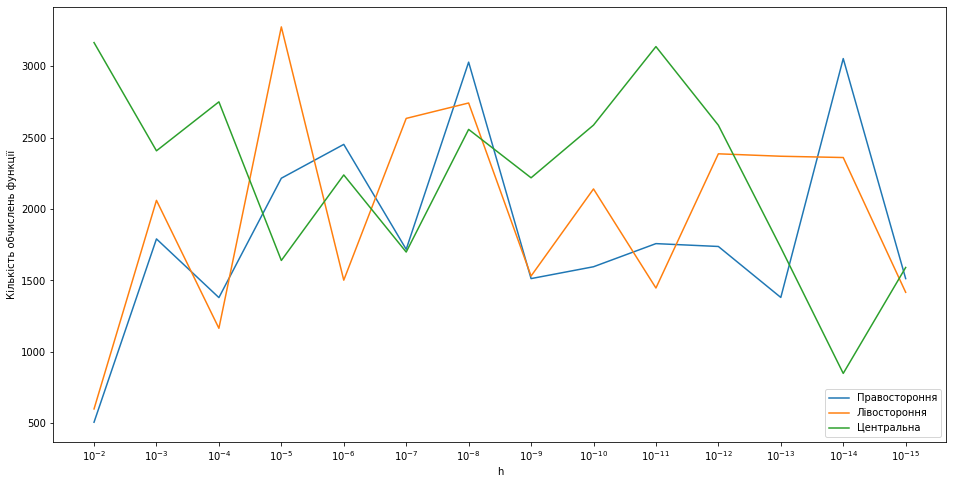

In [12]:
# Build plots
plt.figure(figsize=(16, 8))
plt.semilogx(h_values, rightFcalc, label='Правостороння')
plt.semilogx(h_values, leftFcalc, label='Лівостороння')
plt.semilogx(h_values, centerFcalc, label='Центральна')

plt.xticks(h_values)
# Adding a legend and labels
plt.legend()
plt.xlabel('h')
plt.ylabel('Кількість обчислень функції')
plt.gca().invert_xaxis()
# Displaying the plot
plt.show()

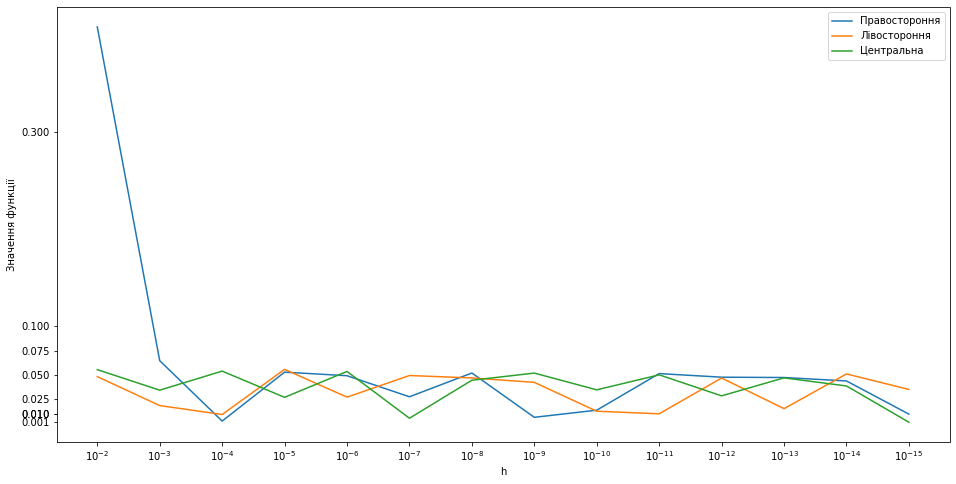

In [13]:
resultsRigthMiminum = list(map(lambda x: f(x), rightMinimum))
resultsLeftMiminum = list(map(lambda x: f(x), leftMinimum))
resultsCenterMiminum = list(map(lambda x: f(x), centerMinimum))

plt.figure(figsize=(16, 8))
plt.semilogx(h_values, resultsRigthMiminum, label='Правостороння')
plt.semilogx(h_values, resultsLeftMiminum, label='Лівостороння')
plt.semilogx(h_values, resultsCenterMiminum, label='Центральна')

plt.xticks(h_values)
plt.yticks([0.001, 0.01, 0.01, 0.025, 0.05, 0.075, 0.1, 0.3])
# Adding a legend and labels
plt.legend()
plt.xlabel('h')
plt.ylabel('Значення функції')
plt.gca().invert_xaxis()
# Displaying the plot
plt.show()

In [14]:
print(min(resultsLeftMiminum))
print(np.round(leftMinimum[resultsLeftMiminum.index(min(resultsLeftMiminum))], 5))
print(leftFcalc[resultsLeftMiminum.index(min(resultsLeftMiminum))])
print()

print(np.round(rightMinimum[resultsRigthMiminum.index(min(resultsRigthMiminum))], 5))
print(np.round(min(resultsRigthMiminum), 5))
print(rightFcalc[resultsRigthMiminum.index(min(resultsRigthMiminum))])
print()


0.009117337538765535
[0.90474 0.8179 ]
1165

[0.95204 0.90578]
0.00234
1380



In [15]:
eMOPvalues = np.array([1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001])
global functionCalculated

gcMinimum = []
dskMinimum = []

gcFCalc = []
dskFCalc = []

h = 0.0000001
e = 0.001

for e in eMOPvalues:
    eGoldenCut = e
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='opt', mop_type='gc')
    gcMinimum.append(res)
    gcFCalc.append(functionCalculated)

for e in eMOPvalues:
    eDSKPauela = e
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='opt', mop_type='dsk')
    dskMinimum.append(res)
    dskFCalc.append(functionCalculated)



ITERATION NUMBER 1
Xk: [-1.2  0. ], Xk+1: [-0.5852571884887916  0.3238771027116833], Lambda: [0.0008837590734775674 0.001124573272925305 ], Fxk: 212.2, Fxk+1: 2.547818403675817, GradFxk: [-695.6000000002405 -288.0000000970995], GradFxk+1: [-7.536269388541683 -3.729774793459484]

ITERATION NUMBER 2
Xk: [-0.5852571884887916  0.3238771027116833], Xk+1: [-0.5701027774723868  0.3341787877252372], Lambda: [0.002010863762307369  0.0027620126104178928], Fxk: 2.547818403675817, Fxk+1: 2.4736162431512905, GradFxk: [-7.536269388541683 -3.729774793459484], GradFxk+1: [-1.0509816350534606  1.8323221695482061]

ITERATION NUMBER 1
Xk: [-1.2  0. ], Xk+1: [-0.5852571884887916  0.3238771027116833], Lambda: [0.0008837590734775674 0.001124573272925305 ], Fxk: 212.2, Fxk+1: 2.547818403675817, GradFxk: [-695.6000000002405 -288.0000000970995], GradFxk+1: [-7.536269388541683 -3.729774793459484]

ITERATION NUMBER 2
Xk: [-0.5852571884887916  0.3238771027116833], Xk+1: [-0.5701027774723868  0.3341787877252372],

KeyboardInterrupt: 

In [ ]:

resultsGCMiminum = list(map(lambda x: f(x), gcMinimum))
resultsDSKMiminum = list(map(lambda x: f(x), dskMinimum))

plt.figure(figsize=(16, 8))
plt.semilogx(eMOPvalues[5:], resultsGCMiminum[5:], label='Золотий переріз')
plt.semilogx(eMOPvalues[5:], resultsDSKMiminum[5:], label='ДСК Пауелла')

plt.xticks(eMOPvalues[5:])
# plt.yticks([0.001, 0.01, 0.01, 0.025, 0.05, 0.075, 0.1, 0.3])
# Adding a legend and labels
plt.legend()
plt.xlabel('e для МОП')
plt.ylabel('Значення функції')
plt.gca().invert_xaxis()
# Displaying the plot
plt.show()

In [ ]:
# Build plots
plt.figure(figsize=(16, 8))
plt.semilogx(eMOPvalues, gcFCalc, label='Золотий переріз')
plt.semilogx(eMOPvalues, dskFCalc, label='ДСК Пауелла')

plt.xticks(eMOPvalues)
# Adding a legend and labels
plt.legend()
plt.xlabel('h')
plt.ylabel('Кількість обчислень функції')
plt.gca().invert_xaxis()
# Displaying the plot
plt.show()

In [ ]:
print(eMOPvalues)
print(np.around(gcMinimum, 5))
printArray(np.around(resultsGCMiminum, 8))
printArray(gcFCalc)

In [ ]:
print(np.around(dskMinimum, 5))
printArray(np.around(resultsDSKMiminum, 8))
printArray(dskFCalc)

In [ ]:
# Зміна параметру Свена
svenCoefs = np.array([10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001,
                      0.0000000001, 0.00000000001, 0.000000000001, 0.0000000000001, 0.00000000000001, 
                      0.000000000000001])

x0 = np.array([-1.2, 0])
h = 10**(-15) #0.0000001
e = 0.001
eGoldenCut = 0.001

svenMinimum = []
svenFcalc = []
svenF = []

for s in svenCoefs:
    functionCalculated = 0
    svenCoefLambda = s
    res = MSD(x0, h, e, derType='center', l_type='opt', mop_type='gc')
    svenMinimum.append(res)
    svenFcalc.append(functionCalculated)
    svenF.append(f(res))

printArray(svenCoefs)
printArray(np.round(svenMinimum, 5))
printArray(np.round(svenF, 5))
printArray(np.round(svenFcalc, 5))

In [ ]:
# Testing end criteria
x0 = np.array([-1.2, 0])
h = 0.000000000000001 # 0.0000001
eArray = np.array([0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]) # 0.0000001, 0.00000001]) # 0.000000001,
                      # 0.0000000001, 0.00000000001, 0.000000000001, 0.0000000000001, 0.00000000000001, 
                      # 0.000000000000001])
eGoldenCut = 0.001
svenCoefLambda = 1
functionCalculated = 0
functionCalculatedForLambda = 0

fchangeMinimum = []
fchangeFcalc = []
fchangeF = []

# eArray = np.array([0.001])
for e in eArray:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='opt', mop_type='gc', stopCriteria='fchange')
    fchangeMinimum.append(res)
    fchangeFcalc.append(functionCalculated)
    fchangeF.append(f(res))

'''
gradMinimum = []
gradFcalc = []
gradF = []

for e in eArray:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='opt', mop_type='gc', stopCriteria='grad')
    gradMinimum.append(res)
    gradFcalc.append(functionCalculated)
    gradF.append(f(res))
'''


In [ ]:
print(fchangeFcalc)
print(fchangeF)

In [ ]:
from scipy.optimize import minimize
def rosenbrok(x):
    return 100*(x[0]**2-x[1])**2 + (x[0]-1)**2
result = minimize(rosenbrok, x0, method='CG')
print(result)

In [ ]:
# Дослідження методу Бута
x0 = np.array([-1.2, 0])
h = 0.0000001 # 0.0000001
eDSKPauela = 0.001
eGoldenCut = 0.0001
svenCoefLambda = 1
functionCalculated = 0
functionCalculatedForLambda = 0
eArray = np.array([0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001])

withoutModMinimum = []
withoutModFcalc = []
withoutModF = []

for e in eArray:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='opt', mop_type='gc', stopCriteria='fchange')
    withoutModMinimum.append(res)
    withoutModFcalc.append(functionCalculated)
    withoutModF.append(f(res))

boothModMinimum = []
boothModFcalc = []
boothModF = []

for e in eArray:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='opt', mop_type='gc', stopCriteria='fchange', modMethod='booth')
    boothModMinimum.append(res)
    boothModFcalc.append(functionCalculated)
    boothModF.append(f(res))

In [ ]:
printArray(np.round(withoutModMinimum, 6))
printArray(withoutModFcalc)
printArray(withoutModF)

printArray(np.round(boothModMinimum, 6))
printArray(boothModFcalc)
printArray(boothModF)

In [ ]:
# Дослідження методу Бута
x0 = np.array([-1.2, 0])
h = 0.0000001 # 0.0000001
eDSKPauela = 0.001
eGoldenCut = 0.0001
svenCoefLambda = 1
functionCalculated = 0
functionCalculatedForLambda = 0
eArray = np.array([0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001])

withoutModMinimum = []
withoutModFcalc = []
withoutModF = []

for e in eArray:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='const', mop_type='gc', stopCriteria='fchange')
    withoutModMinimum.append(res)
    withoutModFcalc.append(functionCalculated)
    withoutModF.append(f(res))

lustrModMinimum = []
lustrModFcalc = []
lustrModF = []

'''
for e in eArray:
    functionCalculated = 0
    res = MSD(x0, h, e, derType='center', l_type='const', mop_type='gc', stopCriteria='fchange', modMethod='lustr')
    lustrModMinimum.append(res)
    lustrModFcalc.append(functionCalculated)
    lustrModF.append(f(res))
'''

In [ ]:
printArray(np.round(withoutModMinimum, 6))
printArray(withoutModFcalc)
printArray(withoutModF)

In [25]:
pathOfUOoptimizer = []

BASEDR = 1

def f(x):
    x1 = x[0]
    x2 = x[1]
    global functionCalculated
    functionCalculated += 1
    if x1**2 + x2**2 <= 1:
        R = 0
    else: 
        global BASEDR
        R = BASEDR
    return 100*(x1**2-x2)**2 + (x1-1)**2 + R*(1-x1**2-x2**2)**2

x0 = np.array([1, -1]) # -3 -3 10000000 e = 0.001
h = 0.0000001 # 0.0000001
e = 0.00001
eDSKPauela = 0.001
eGoldenCut = 0.001
svenCoefLambda = 10**(-5)
functionCalculated = 0
functionCalculatedForLambda = 0


eUO = 0.00001

R = 0.1
x = x0
while True:
    R = R*10
    BASEDR = R
    res = MSD(x, h, e, derType='center', l_type='opt', mop_type='gc', stopCriteria='fchange', iprint=1000)
    pathOfUOoptimizer.extend(pathOfMethod)
    if stopCriteria1(x, f(x), res, f(res), eUO):
        break
    x = res
    print(res)
print(functionCalculated)

[0.8014707441936457 0.6416578969122044]
[0.78811758653258   0.6203903450220783]
[0.7865876041177939 0.6179712063007933]
[0.7864183766592014 0.617748604118371 ]
[0.786400212440697  0.6177252539313965]
3298


C:\Users\Bohdan\AppData\Local\Temp\ipykernel_3472\2129167588.py:32: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(1, 1, 'ro', label='БО Minimum', color = 'Green')
C:\Users\Bohdan\AppData\Local\Temp\ipykernel_3472\2129167588.py:38: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(1, 1, 'ro', label='БО Minimum', color = 'Green')


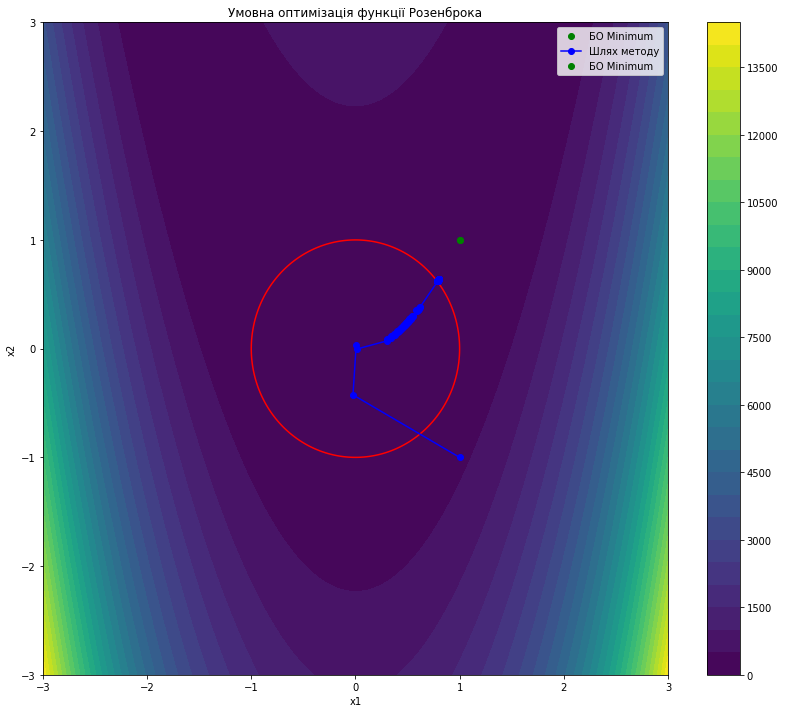

In [21]:

def freal(x):
    x1 = x[0]
    x2 = x[1]
    return 100*(x1**2-x2)**2 + (x1-1)**2

def area(x):
    x1 = x[0]
    x2 = x[1]
    return x1**2 + x2**2 - 1

# Generate data points for plotting
x = np.linspace(-3, 3, 1000)
y = np.linspace(-3, 3, 1000)
X, Y = np.meshgrid(x, y)
Z_freal = freal([X, Y])
Z_area = area([X, Y])

# Create a 2D plot for freal
fig, ax = plt.subplots(figsize=(14, 12))
cmap = ax.contourf(X, Y, Z_freal, levels=30, cmap='viridis')

# Add contour lines for area
contour = ax.contour(X, Y, Z_area, levels=[0], colors='red')

# Set labels and title
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Умовна оптимізація функції Розенброка')

# Add a colorbar
cbar = fig.colorbar(cmap)
ax.plot(1, 1, 'ro', label='БО Minimum', color = 'Green')

# Plot the pathOfMethod
path_x = [point[0] for point in pathOfUOoptimizer]
path_y = [point[1] for point in pathOfUOoptimizer]
ax.plot(path_x, path_y, 'bo-', label='Шлях методу')
ax.plot(1, 1, 'ro', label='БО Minimum', color = 'Green')

# Show the legend
ax.legend()

# Show the plot
plt.show()